In [1]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.preprocessing import label_binarize,scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize,StandardScaler
from nitime import algorithms as alg


C:\Anaconda3\lib\site-packages\pandas\__init__.py:7: DeprecationWarning: bad escape \s
  from pandas import hashtable, tslib, lib
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
C:\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
C:\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
C:\Anaconda3\lib\site-packages\ipykernel\pylab\

In [2]:
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 'pineline 13.csv', 'pipe line 10', 'pipe line 10.csv', 'pipeline 13.pickle', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'Sleep Stage Scoring Criteria.docx', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj13_l2nap_day2 edited.edf', 'suj13_l2nap_day2 edited1.edf', 'suj13_l2nap_day2 edited1_annotations.txt', 'suj13_l2nap_day2 edited_annotations.txt', 'suj13_l2nap_day2 edited_C3.txt', 'suj13_l2nap_day2 edited_C4.txt', 'suj13_l2nap_day2 edited_F3.txt', 'suj13_l2nap_day2 edited_F4.txt', 'suj13_l2nap_day2 edited_O1.txt', 'suj13_l2nap_day2 edited_O2.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_annotations.txt', 'suj9_d1final.edf', 'suj9_d1final_annotations.txt', 'su

In [6]:
resolution = 1;result={}

# where two intervals overlap
def getOverlap(a,b):
    return max(0,min(a[1],b[1]) - max(a[0],b[0]))

for num, EDFfileName in enumerate(EDFfiles):
    if EDFfileName == 'suj13_l2nap_day2 edited.edf' or EDFfileName =='suj13_l2nap_day2 edited1.edf':
        pass
    else:
        file_to_read,fileName=eegPinelineDesign.pick_sample_file(EDFfiles,n=num)
        # channel list for artifact(eyemovement or chewing) removal - ROC and/or LOC
        channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
        raw = eegPinelineDesign.load_data(file_to_read,channelList,None, None)# No pass
        annotation_to_read = [x for x in Annotationfiles if fileName in x]
        file = pd.read_csv(annotation_to_read[0])
        labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
        spindles=[]# take existed annotations
        for row in file.iterrows():
            currentEvent = row[1][-1]
            if labelFind.search(currentEvent):
                spindles.append(row[1][0])# time of marker
                
                
        sleep_annoation=[]
        searchLabel = re.compile('Markon: 2',re.IGNORECASE)
        for rows in file.iterrows():
            currentEvent = rows[-1][-1]
            if searchLabel.search(currentEvent):
                sleep_annoation.append([rows[1][0],rows[1][0]+30])
                
                
        
        # threshold test to detect possible spindle segments
        channelList=['F3','F4','C3','C4','O1','O2']
        windowsize = 5;ratio_index={};muscle_index={};sample_ind={}
        
        for ii,names in enumerate(channelList):
            #initialize
            endPoint=windowsize;startPoint=endPoint-windowsize
            distance_to_end = raw.last_samp/1000 - endPoint
            ratio_index[names] =[];muscle_index[names]=[];sample_ind[names]=[];
        
            # start the while loop
            while distance_to_end > windowsize:    
                start, stop = raw.time_as_index([startPoint,endPoint])
                tempSegment, time = raw[ii,start:stop]
                
                
                    
                filter_alpha = mne.filter.band_pass_filter(tempSegment[0,:],1000,8,12.5) #band pass alpha
                RMS_alpha = np.sqrt(sum(filter_alpha**2)/len(filter_alpha))
                
                filter_spindle = mne.filter.band_pass_filter(tempSegment[0,:],1000,11.5,16.5)# band pass 11.5 - 16
                RMS_spindle = np.sqrt(sum(filter_spindle**2)/len(filter_spindle))
                
                filter_muscle = mne.filter.band_pass_filter(tempSegment[0,:],1000,30,40.5) # band pass 30 - 40, muscle movement
                RMS_muscle = np.sqrt(sum(filter_muscle**2)/len(filter_muscle))
                
                point=[0,0]
                if RMS_alpha/RMS_spindle < 1.2:# very subjective value
                    point[0] += 2
                    ratio_index[names].append(2)
                else:
                    point[0] += -1
                    ratio_index[names].append(-1)
                    
                if RMS_muscle > 5*10e-4:
                    point[1] += -1
                    muscle_index[names].append(-1)
                else:
                    point[1] += 1
                    muscle_index[names].append(1)
                    
                sample_ind[names].append(sum(point))
                
                endPoint += resolution
                startPoint=endPoint - windowsize
                distance_to_end = raw.last_samp/1000 - endPoint
            sample_ind[names].append(0)
        general_result = pd.DataFrame(sample_ind)
        
        mark_pairs={};indicator={}
        for ii,names in enumerate(channelList):
            mark_pairs[names]=[];indicator[names]=[]
            for pos,items in enumerate(general_result[names]):
                if pos == len(general_result[names])-1:
                    pass
                else:
                    
                    indicator[names].append(general_result[names][pos+1]-general_result[names][pos])
                    
                    if indicator[names][pos] == -3:
                        endPoint = pos*resolution
                        initial_position=pos;position_idx=pos
                        try:
                            while indicator[names][initial_position] != 3:
                                position_idx -= 1 # backward search
                                initial_position = position_idx
                            startPoint = position_idx * resolution
                            
                            if endPoint - startPoint >= 1:
                                mark_pairs[names].append((startPoint,endPoint))
                                
                        except:
                            pass
                        
        # spindle checking
        spindle_overlapping=[]
        for items in spindles:
            spindle_overlapping_temp=[]
            for names in channelList:
                if any(lower<items<upper for (lower,upper) in mark_pairs[names]):
                    spindle_overlapping_temp.append(items)
            spindle_overlapping.append(list(set(spindle_overlapping_temp)))
            
            
        # sleeping checking
        sleeping_overlapping ={}
        for names in channelList:
            sleeping_overlapping[names]=[]
            for items in sleep_annoation:
                for intervals in mark_pairs[names]:
                    if getOverlap(list(intervals),items) is not 0:
                        sleeping_overlapping[names].append(list(intervals))
                        
                        
        result[EDFfileName]={'general result':general_result,
                            'marker pairs':mark_pairs,
                            'spindle overlapping':spindle_overlapping,
                            'spindle annotations':spindles,
                            'sleeping overlapping':sleeping_overlapping,
                            'sleeping annotations':sleep_annoation}

Extracting edf Parameters from s5d2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3383999  =      0.000 ...  3383.999 secs...
[done]
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    5, 6, 0, 0, 7
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components
Extracting edf Parameters from s6n2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 2073999  =      0.000 ...  2073.999 secs...
[done]
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may tak

C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 7.5Hz is only 18.1dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 17.0Hz is only 17.9dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 29.5Hz is only 17.9dB.
  '%0.1fdB.' % (att_freq, att_db))


In [7]:
import pickle

In [8]:
with open('pipeline 13.pickle','wb') as handle:
    pickle.dump(result,handle)

In [10]:
result = pd.DataFrame(result)

In [11]:
result.to_csv('pineline 13.csv',sep='\t')

# After result

In [8]:
import pickle

In [9]:
with open('pipeline 13.pickle','rb') as handle:
    result = pickle.load(handle)

In [12]:
result['s5d2_final.edf'].keys()

dict_keys(['sleeping annotations', 'spindle annotations', 'spindle overlapping', 'general result', 'marker pairs', 'sleeping overlapping'])

In [13]:
EDFfiles[1]

's6n2_final.edf'

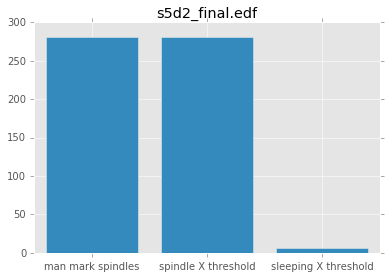

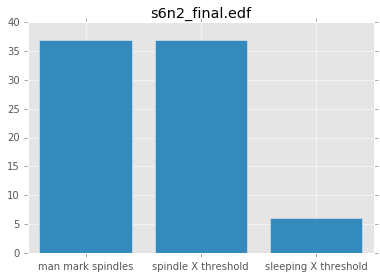

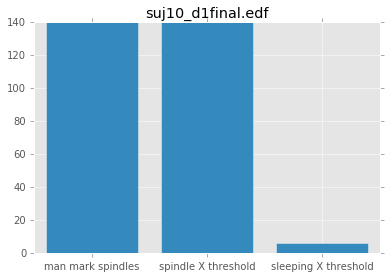

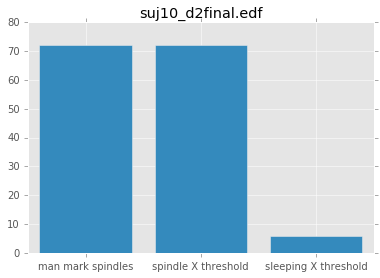

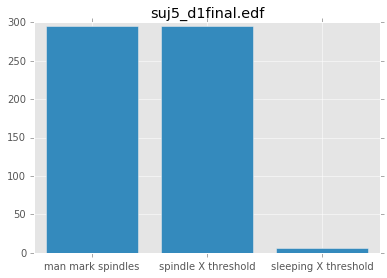

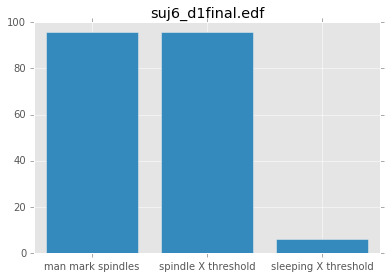

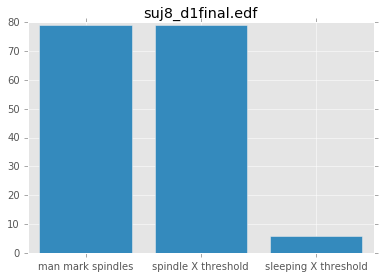

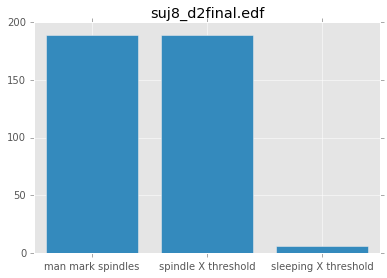

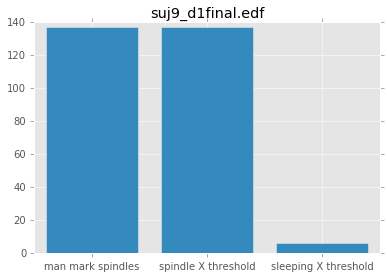

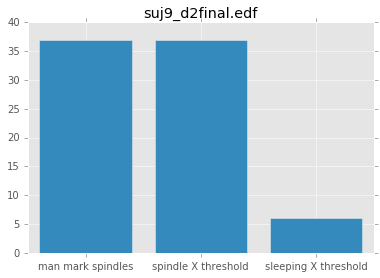

In [27]:
for num, EDFfileName in enumerate(EDFfiles):
    if EDFfileName == 'suj13_l2nap_day2 edited.edf' or EDFfileName =='suj13_l2nap_day2 edited1.edf':
        pass
    else:
        f=plt.figure()
        ax =f.add_axes([0.1,0.1,0.8,0.8])
        ax.bar([0,1,2],[len(result[EDFfiles[num]]['spindle annotations']),
                len(result[EDFfiles[num]]['spindle overlapping']),
                   len(result[EDFfiles[num]]['sleeping overlapping'])],0.8,align='center')
        plt.title(EDFfiles[num])
        ax.set_xticks([0,1,2])
        ax.set_xticklabels(['man mark spindles','spindle X threshold','sleeping X threshold'])